In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Custom
import functions as f
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# PATHS = {
#     'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
#     'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
#     'sct_dir':         '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/',
# }

In [3]:
####-----------####
#### FUNCTIONS ####
####-----------####

### MODEL
def coriolis(lat):
    '''Absolute vorticity.
    Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / r) * np.gradient(r * v, dr)

def h80(r, vm, rm, B, lat, vmin=0):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = vmin + np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

In [4]:
rs = np.linspace(10, 5e5, 50000)
vmx = 50
rmx = 50000
B   = 2
lat = 20
K   = 50 # m2/s
Cd  = 2e-3

v   = h80(rs, vmx, rmx, B, lat)
fcor= coriolis(lat)

# plt.plot(rs, v);plt.grid()

In [5]:
def I(r, v, fcor):
    dr   = np.unique(np.diff(r))[0] # meters
    ksi  = 2 * v / r + fcor
    zeta = np.gradient(v, dr) + v / r + fcor
    return np.sqrt(ksi * zeta)

def delta(K, i):
    return np.sqrt(2 * K / i)

def nu(v, Cd, delta, K):
    return Cd * v * delta / K

def a1(nu):
    num = - nu * (nu + 1)
    den = 2 * nu ** 2 + 3 * nu + 2
    return (num / den)

def a2(nu):
    num = nu
    den = 2 * nu ** 2 + 3 * nu + 2
    return (num / den)

def v_prime(r, v, fcor, Cd, K):
    i = I(r, v, fcor)
    d = delta(K, i)
    n = nu(v, Cd, d, K)
    return v * a1(n)

def ki(r, v, fcor):
    dr   = np.unique(np.diff(r))[0] # meters
    ksi  = 2 * v / r + fcor
    zeta = np.gradient(v, dr) + v / r + fcor
    return np.sqrt(ksi / zeta)

def u(r, v, fcor, Cd, K):
    i = I(r, v, fcor)
    d = delta(K, i)
    n = nu(v, Cd, d, K)
    return - ki(r, v, fcor) * v * a2(n)

In [6]:
K2  = np.linspace(10, 50, 50000)
Cd2 = np.linspace(2e-3, 2e-4, 50000)

/tmp/ipykernel_4227/2304366026.py:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(rs, 30 * (-u(rs, v, fcor, Cd, K) / (v + v_prime(rs, v, fcor, Cd, K))), c='purple', linestyle='--', label='tan a')


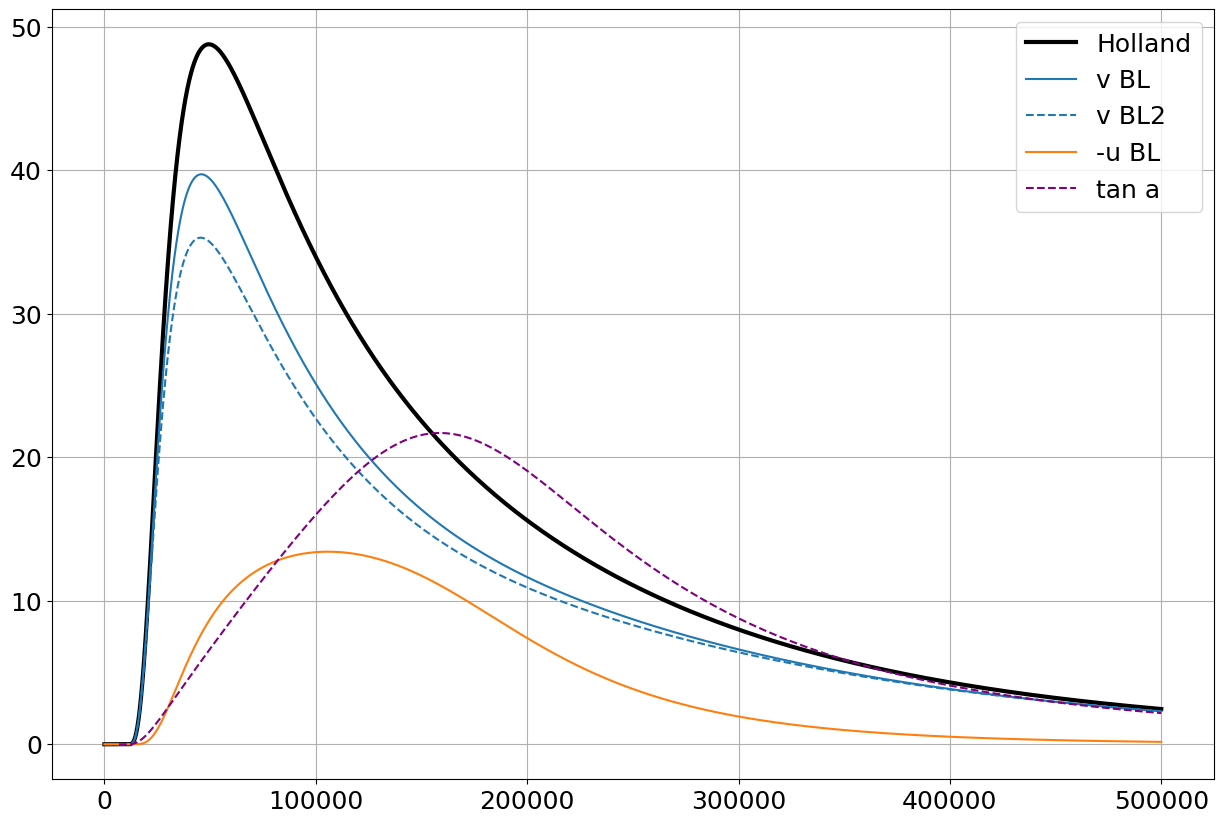

In [7]:
plt.plot(rs, v, c='k', linewidth=3, label='Holland')
plt.plot(rs, v + v_prime(rs, v, fcor, Cd, K), c='tab:blue', label='v BL')
plt.plot(rs, v + v_prime(rs, v, fcor, Cd, K2), c='tab:blue', label='v BL2', linestyle='--')
# plt.plot(rs, v + v_prime(rs, v, fcor, Cd2, K), c='tab:blue', label='v BL2', linestyle='--')
plt.plot(rs, -u(rs, v, fcor, Cd, K), c='tab:orange', label='-u BL')
plt.plot(rs, 30 * (-u(rs, v, fcor, Cd, K) / (v + v_prime(rs, v, fcor, Cd, K))), c='purple', linestyle='--', label='tan a')
plt.grid();plt.legend()

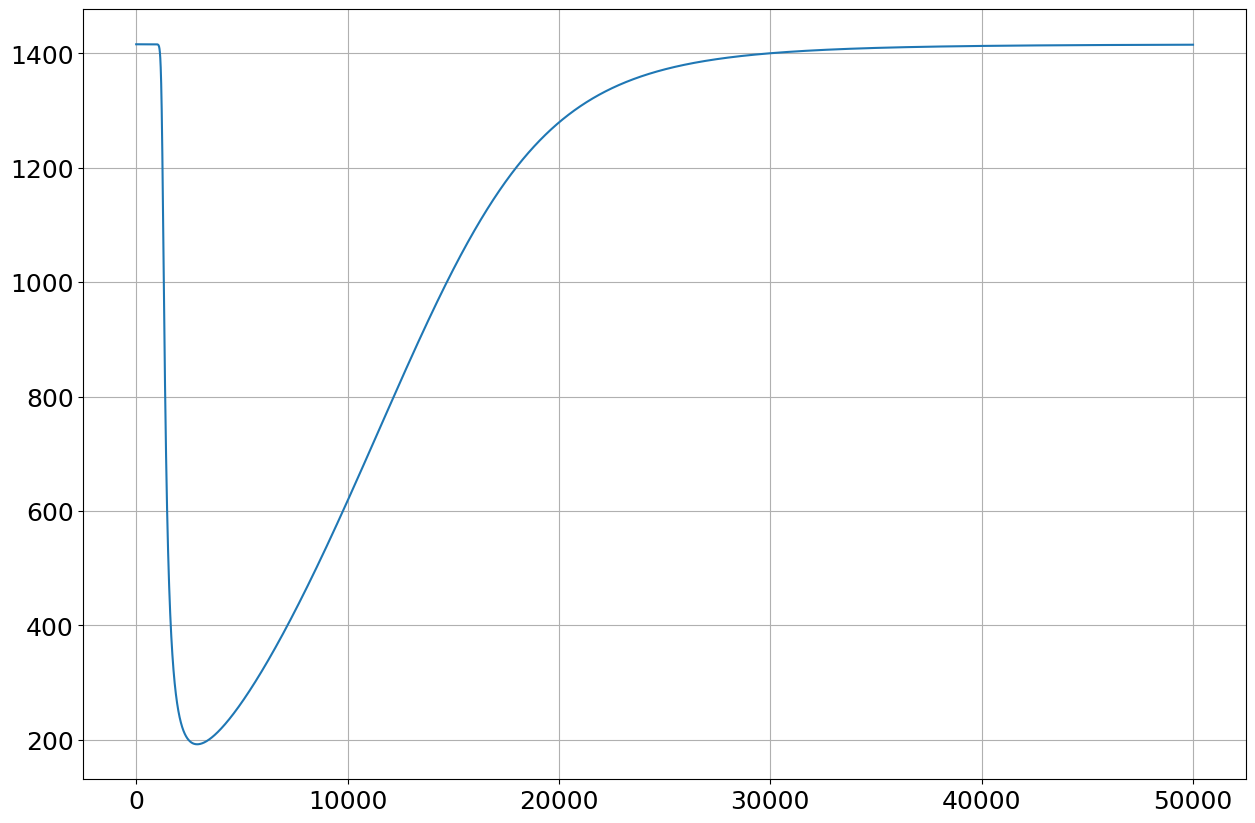

In [8]:
plt.plot(delta(K, I(rs, v, fcor)));plt.grid()

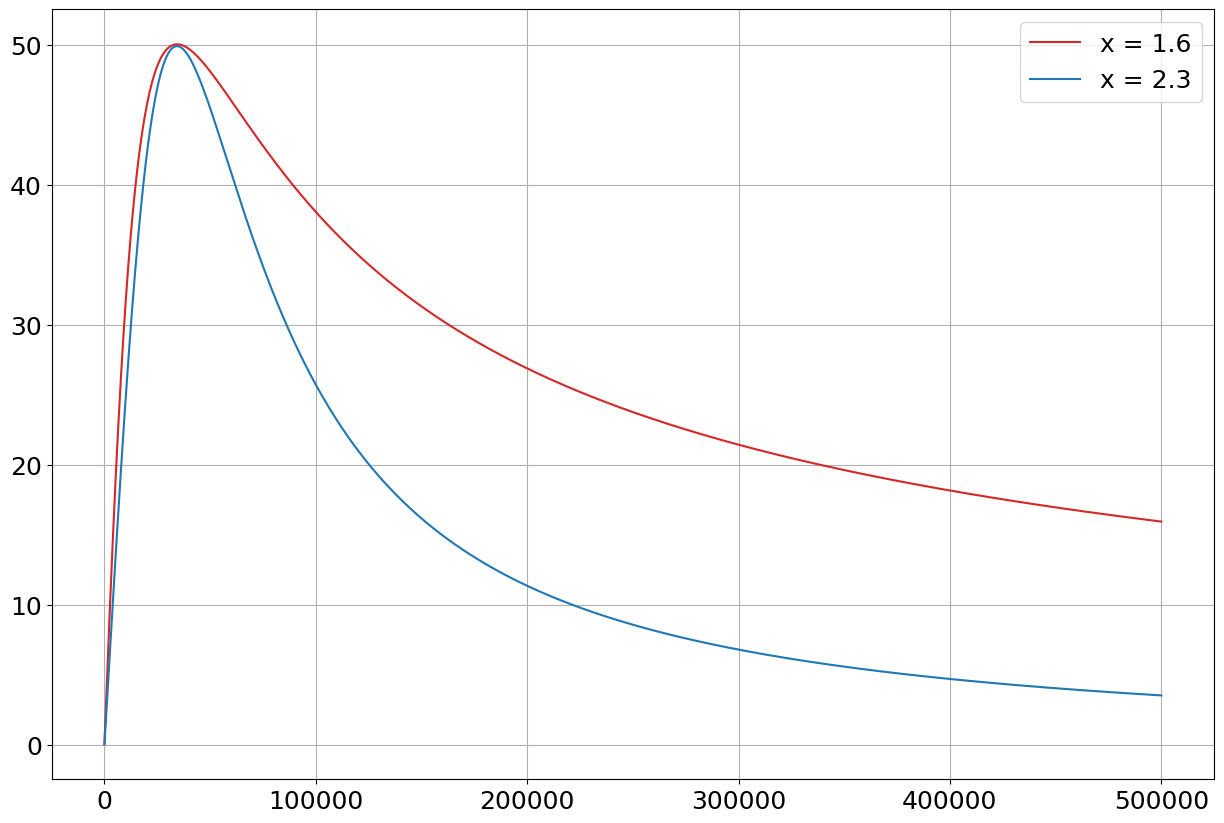

In [9]:
def sm20(r, nu1, sm, rm, x):
    s   = sm * r / rm
    return nu1 * s / (1 + s ** x)

v16 = sm20(rs, 97, 2, 50000, x=1.6)
v23 = sm20(rs, 99, 1.3, 50000, x=2.3)

plt.plot(rs, v16, label='x = 1.6', c='tab:red')
plt.plot(rs, v23, label='x = 2.3', c='tab:blue')
plt.grid();plt.legend()

In [10]:
# plt.plot(np.gradient(v16, d))

In [11]:
# ksi  = 2 * v16 / rs + fcor
# zeta = np.gradient(v16, d) + v16 / rs + fcor
# plt.plot(ksi - zeta)

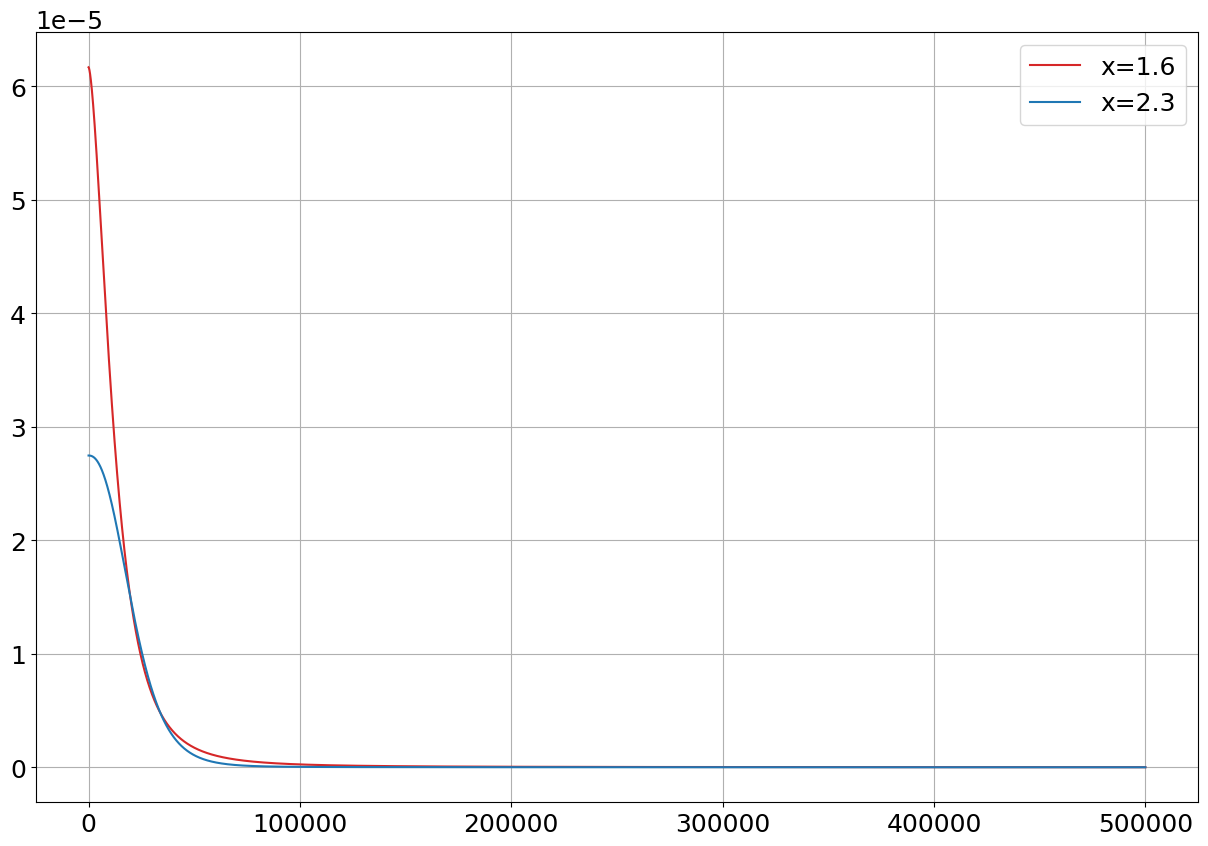

In [12]:
fcor = coriolis(40)
plt.plot(rs, I(rs, v16, fcor) ** 2, label='x=1.6', c='tab:red')
plt.plot(rs, I(rs, v23, fcor) ** 2, label='x=2.3', c='tab:blue')
plt.grid();plt.legend()

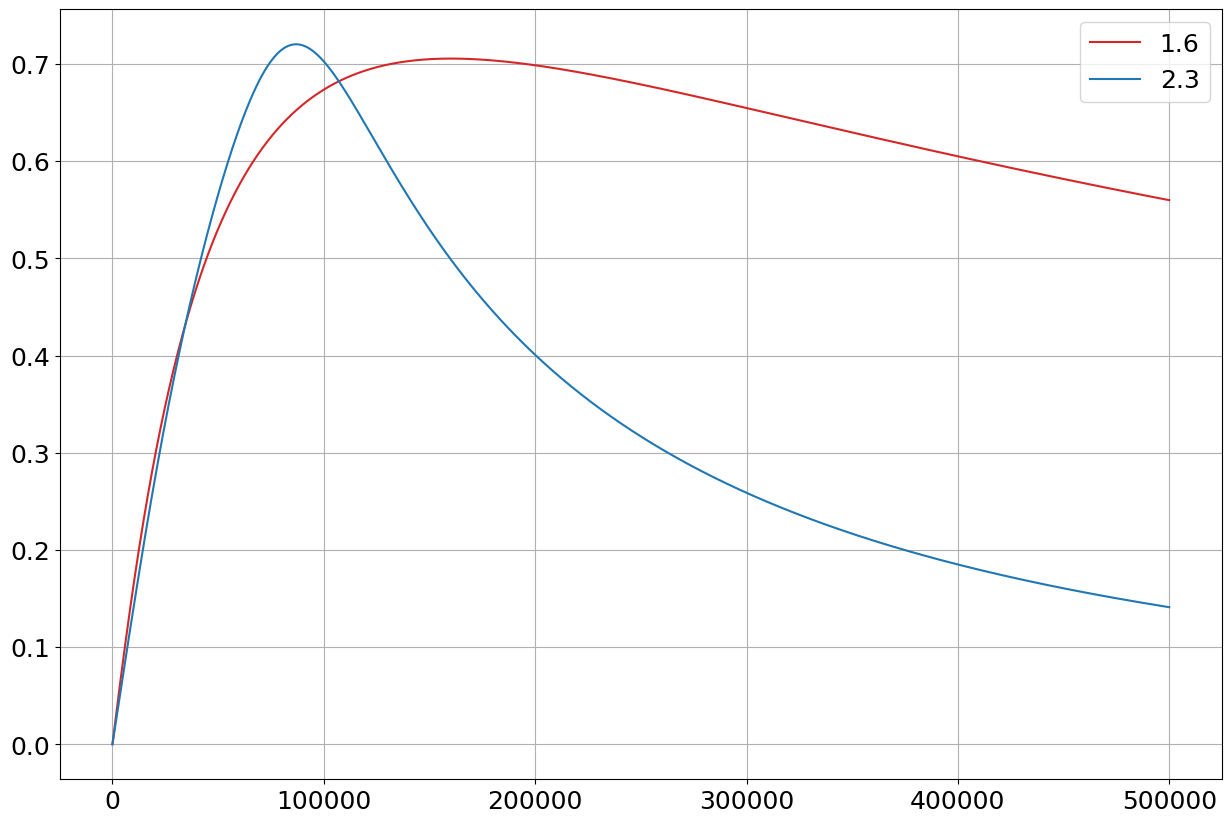

In [13]:
nu16 = nu(v16, Cd, delta(K, I(rs, v16, fcor)), K)
nu23 = nu(v23, Cd, delta(K, I(rs, v23, fcor)), K)
          
plt.plot(rs, nu16, label='1.6', c='tab:red')
plt.plot(rs, nu23, label='2.3', c='tab:blue')
plt.grid();plt.legend()

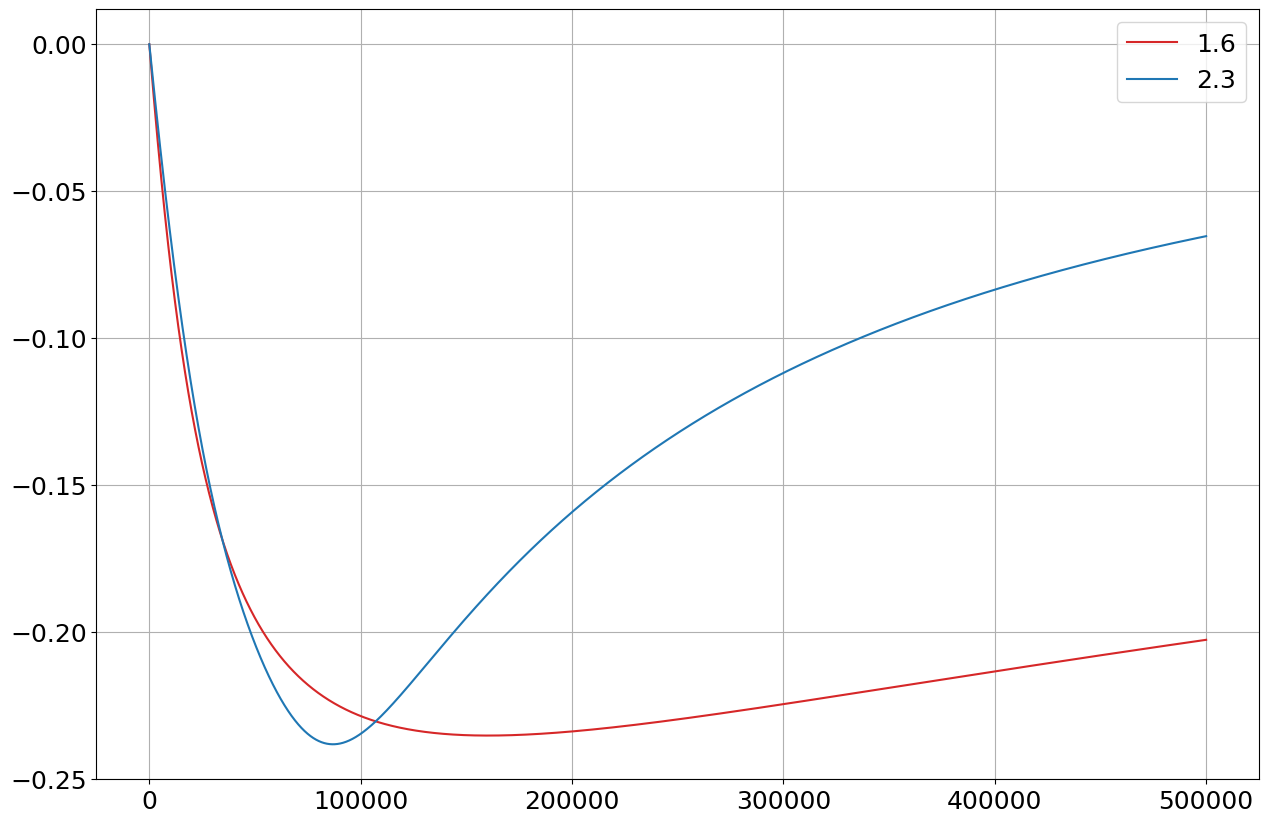

In [14]:
plt.plot(rs, a1(nu16), label='1.6', c='tab:red')
plt.plot(rs, a1(nu23), label='2.3', c='tab:blue')
plt.grid();plt.legend()

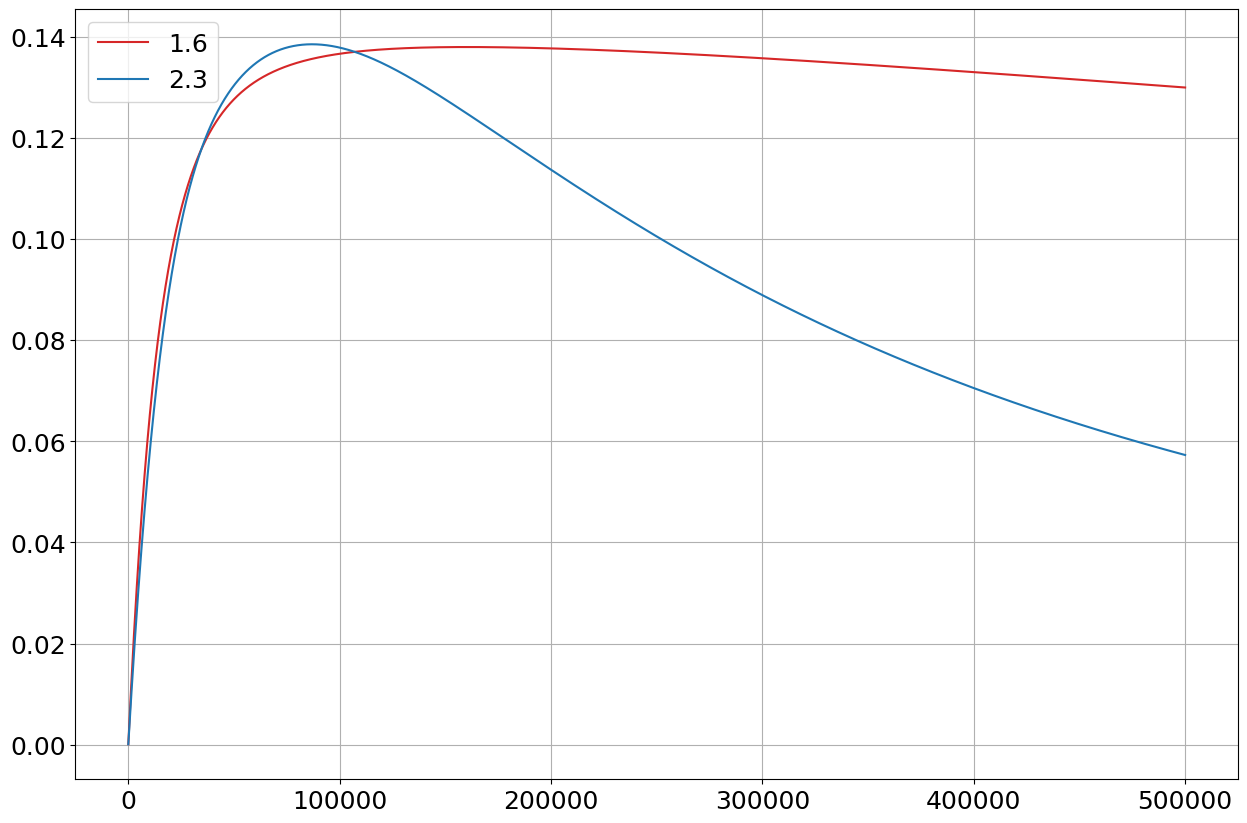

In [15]:
plt.plot(rs, a2(nu16), label='1.6', c='tab:red')
plt.plot(rs, a2(nu23), label='2.3', c='tab:blue')
plt.grid();plt.legend()

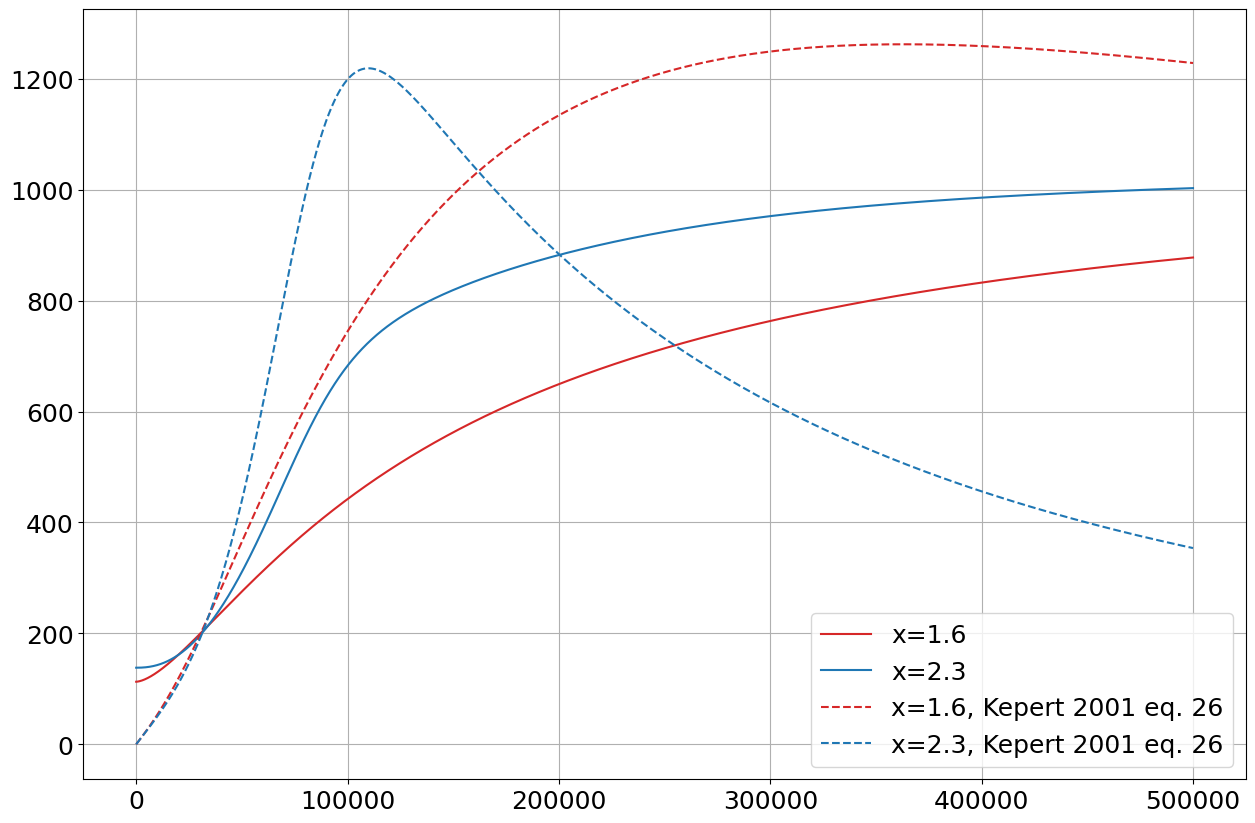

In [16]:
plt.plot(rs, np.sqrt(2 * K / I(rs, v16, fcor)), label='x=1.6', c='tab:red')
plt.plot(rs, np.sqrt(2 * K / I(rs, v23, fcor)), label='x=2.3', c='tab:blue')
plt.plot(rs, v16 / I(rs, v16, fcor) / 1e2, label='x=1.6, Kepert 2001 eq. 26', c='tab:red', linestyle='dashed')
plt.plot(rs, v23 / I(rs, v23, fcor) / 1e2, label='x=2.3, Kepert 2001 eq. 26', c='tab:blue', linestyle='dashed')
plt.grid();plt.legend()

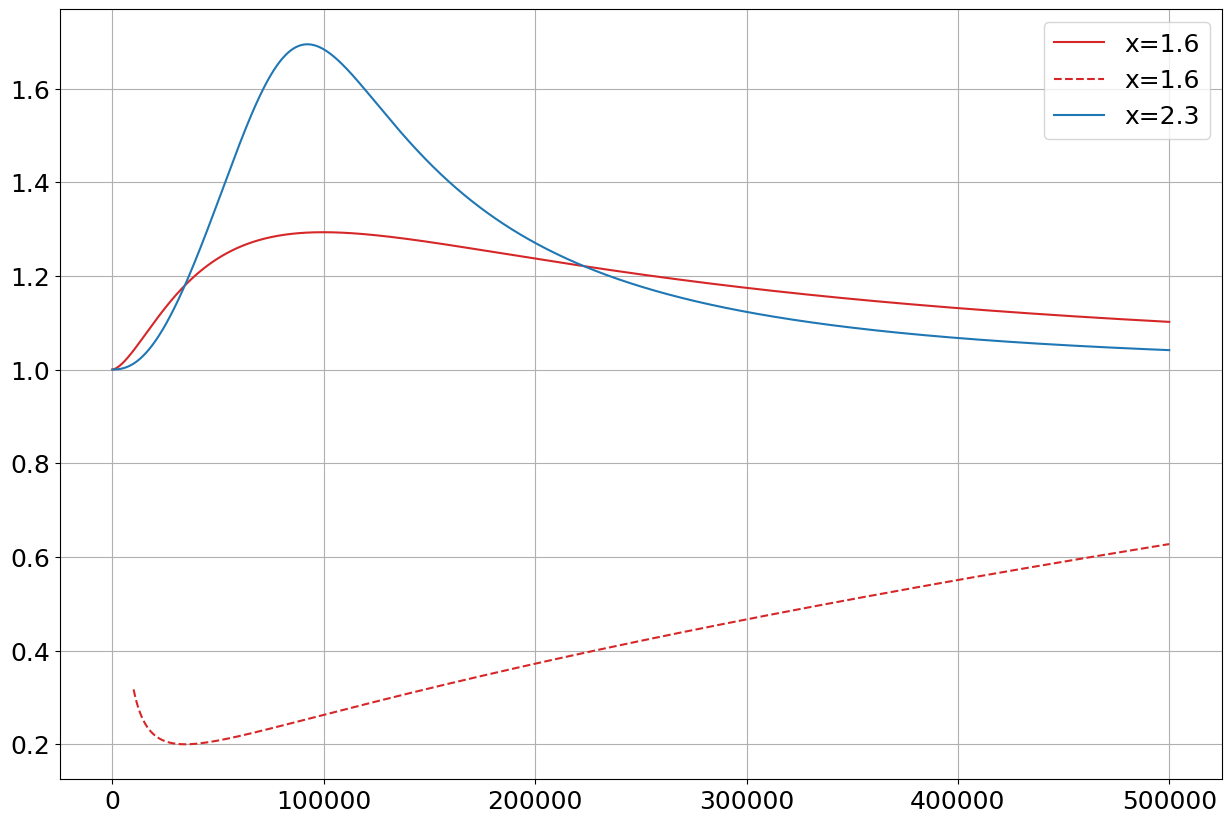

In [17]:
plt.plot(rs, np.sqrt(ki(rs, v16, fcor)), label='x=1.6', c='tab:red')
plt.plot(rs[1000:], (1 / v16)[1000:] * 10, label='x=1.6', c='tab:red', linestyle='--')
plt.plot(rs, np.sqrt(ki(rs, v23, fcor)), label='x=2.3', c='tab:blue')
plt.grid();plt.legend()

#### Test - Eliassen and Lystad 1977

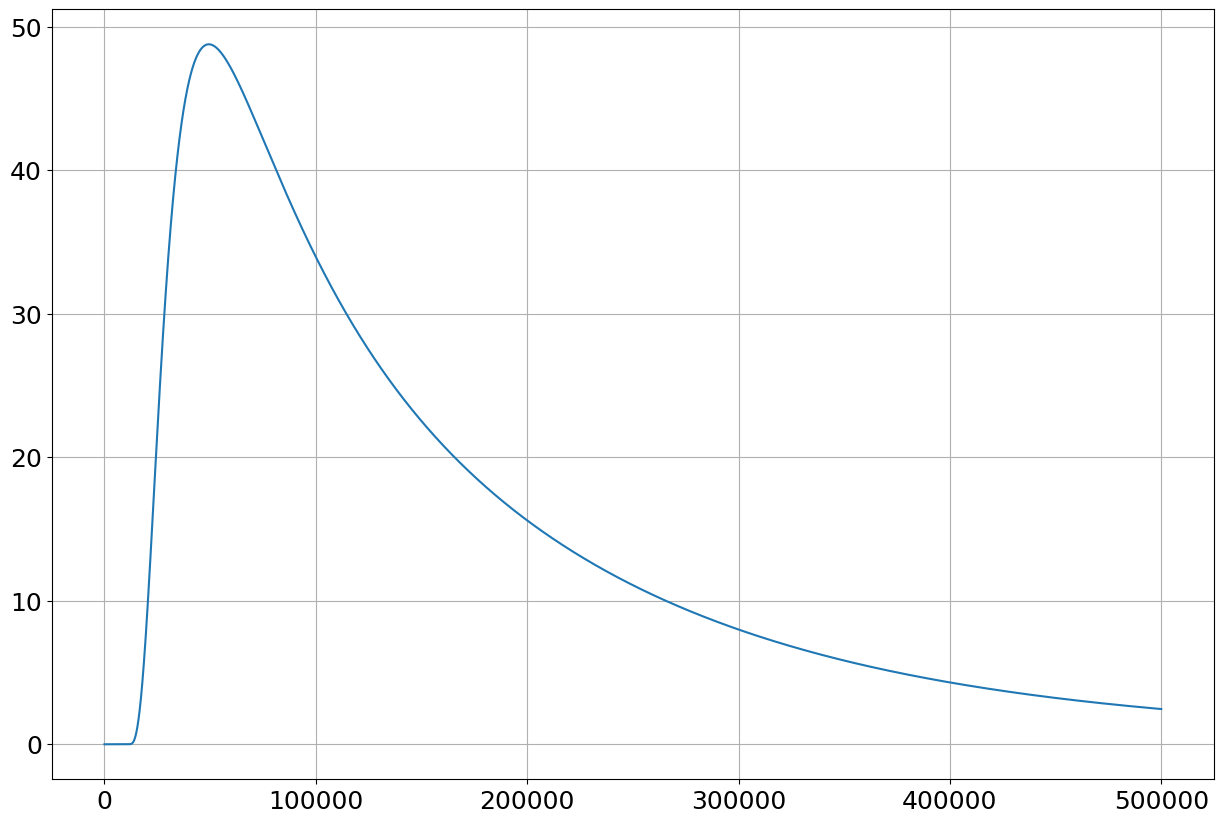

In [18]:
plt.plot(rs, v);plt.grid()

In [19]:
def vorticity(r, v):
    '''Relative vorticity'''
    
    return (1 / r) * np.gradient(r * v, dr)

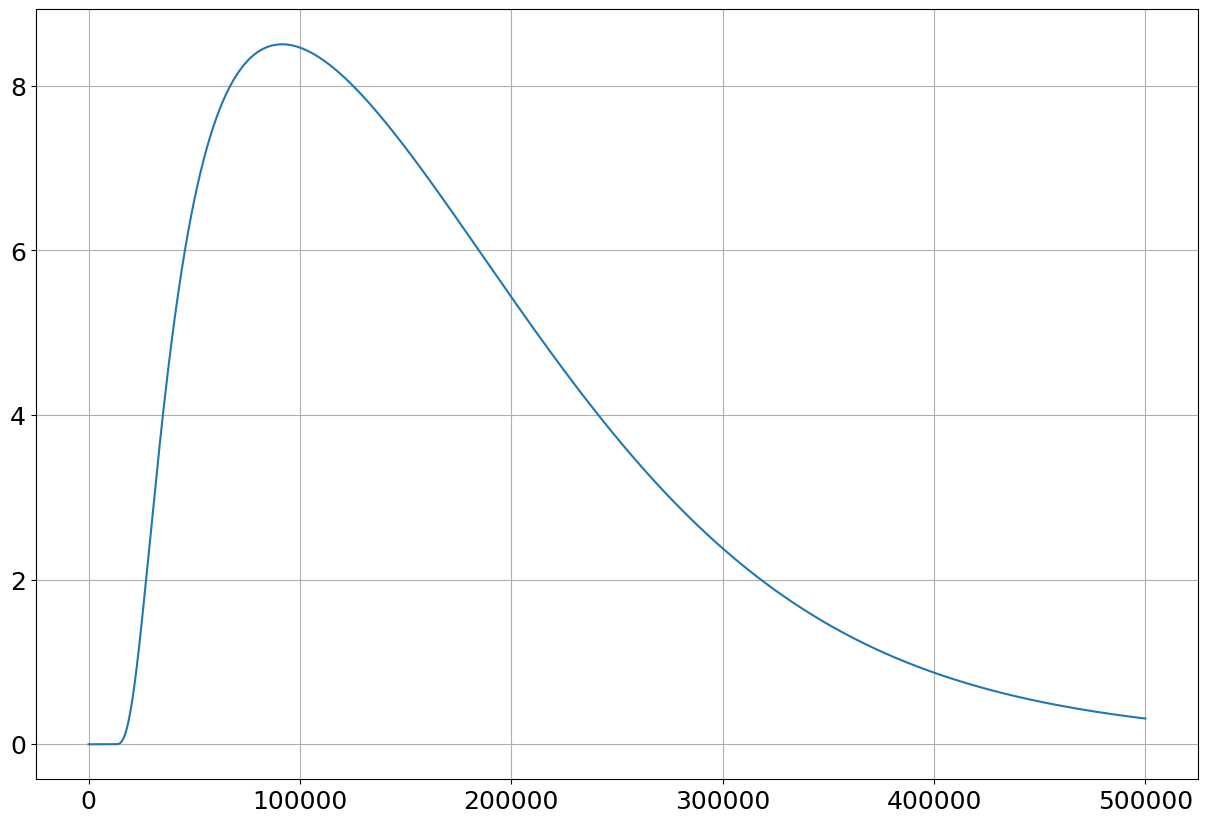

In [20]:
def radial_wind(r, v, fcor, chi, Cd=7e-2, H_h=1e4):
    omg = v / r # Omega. Omega_s = fcor
    dr  = 1000 # meters
    PSI = ((chi ** 2) * Cd * (omg ** 2) * (r ** 3)) / (2 * (fcor + omg) + r * np.gradient(omg, dr))
    return PSI / (H_h * r)

plt.plot(rs, radial_wind(rs, v, coriolis(lat), 0.9));plt.grid()

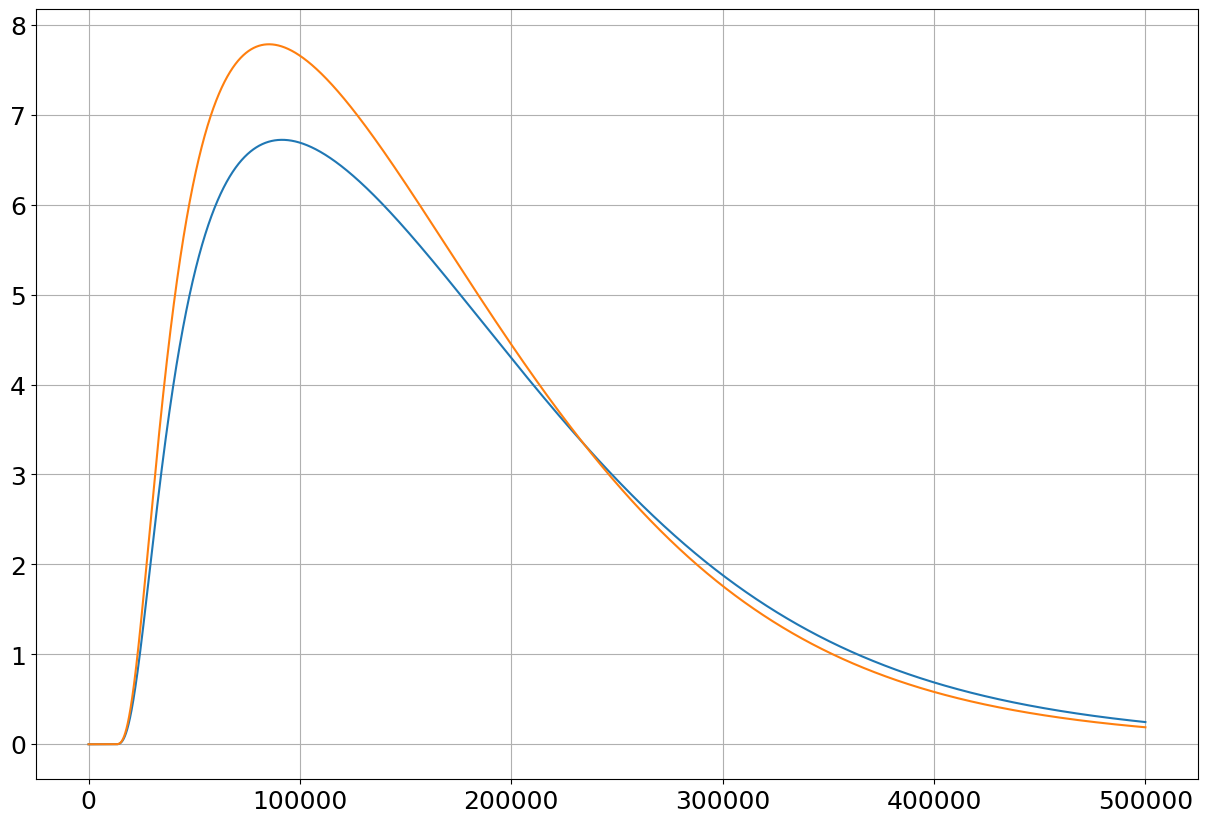

In [21]:
chi = np.linspace(np.log(0.9), np.log(0.7), num=len(rs))
# plt.plot(rs, np.exp(chi));plt.grid()

plt.plot(rs, radial_wind(rs, v, coriolis(lat), 0.8))
plt.plot(rs, radial_wind(rs, v, coriolis(lat), np.exp(chi)));plt.grid()

/tmp/ipykernel_4227/3435930000.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(rs, radial_wind(rs, v, coriolis(lat), 0.9) / v);plt.grid()
/tmp/ipykernel_4227/3435930000.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(rs, radial_wind(rs, v, coriolis(lat), np.exp(chi)) / v);plt.grid()


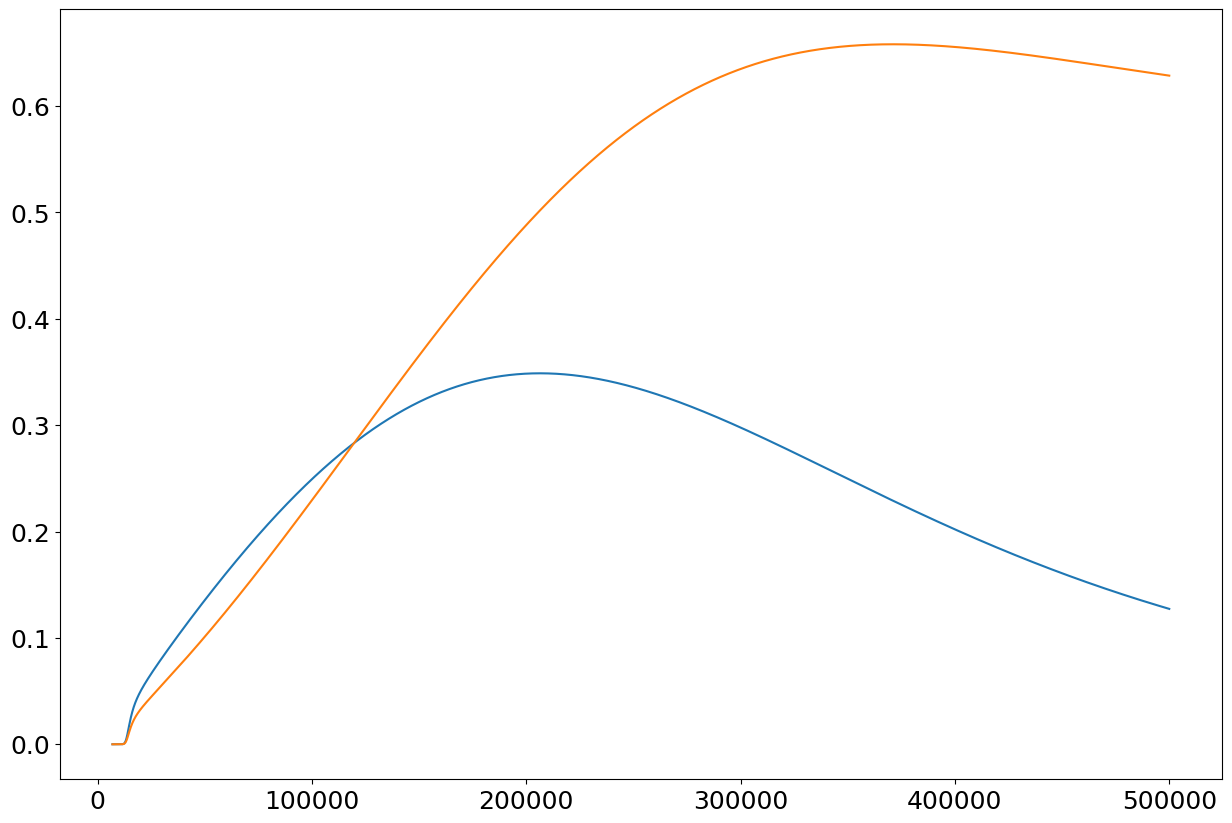

In [22]:
chi = np.linspace(np.log(0.7), np.log(2), num=len(rs))
plt.plot(rs, radial_wind(rs, v, coriolis(lat), 0.9) / v);plt.grid()
plt.plot(rs, radial_wind(rs, v, coriolis(lat), np.exp(chi)) / v);plt.grid()

In [23]:
def omega(r, omg_abs, chi, t, Cd=7e-2, H_h=1e4):
    num = omg_abs * (H_h)
    den = H_h + omg_abs * (chi ** 2) * Cd * r * t
    return num / den

def v_evolved(r, v, fcor, chi, t, Cd=7e-2, H_h=1e4):
    omg   = v / r - fcor
    omg_t = omega(r, abs(omg), chi, t, Cd, H_h)
    return (fcor + np.sign(omg) * omg_t) * r

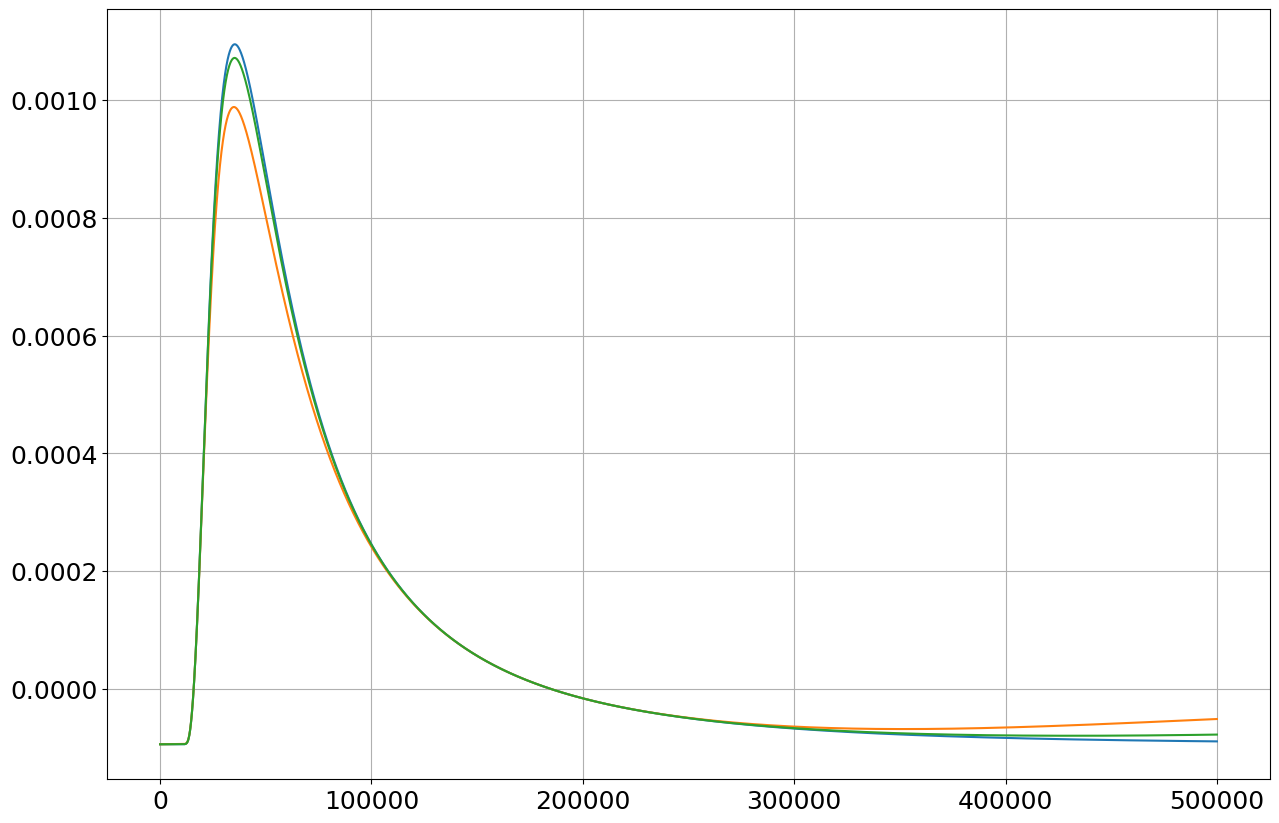

In [24]:
plt.plot(rs, v / rs - fcor);plt.grid()
plt.plot(rs, np.sign(v / rs - fcor) * omega(rs, abs(v / rs - fcor), chi, 5000, Cd=7e-2, H_h=1e4))
plt.plot(rs, np.sign(v / rs - fcor) * omega(rs, abs(v / rs - fcor), chi, 1000, Cd=7e-2, H_h=1e4))

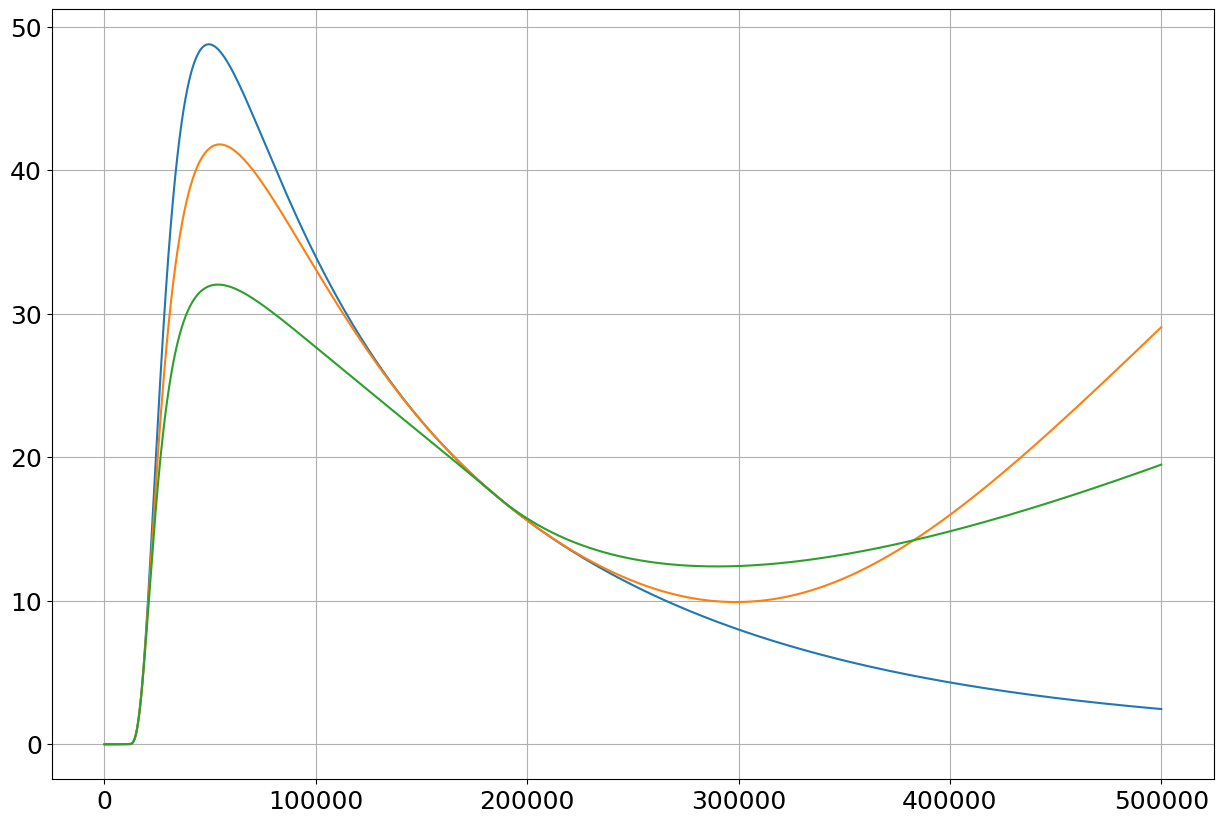

In [25]:
plt.plot(rs, v)
plt.plot(rs, v_evolved(rs, v, fcor, chi, 10000, Cd=7e-2, H_h=1e4))
plt.plot(rs, v_evolved(rs, v, fcor, 0.1, 200000, Cd=7e-2, H_h=1e4))
plt.grid()